In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach()
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=128, num_heads=4, num_layers=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        return self.head(x[:, 0])

    def get_attention_weights(self):
        weights = []
        for block in self.blocks:
            weights.append(block.attn.attn_weights)
        return weights

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(dataloader), correct / total

In [7]:
def visualize_attention(model, image, device, layer_idx=0, head_idx=0):
    model.eval()
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        _ = model(image_input)
        attention_weights = model.get_attention_weights()

    attn = attention_weights[layer_idx][0, head_idx].cpu().numpy()

    cls_attn = attn[0, 1:]
    num_patches = int(np.sqrt(len(cls_attn)))
    cls_attn = cls_attn.reshape(num_patches, num_patches)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    im = axes[1].imshow(cls_attn, cmap='viridis')
    axes[1].set_title(f'Attention Map (Layer {layer_idx+1}, Head {head_idx+1})')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    attn_resized = np.kron(cls_attn, np.ones((image.shape[1]//num_patches, image.shape[2]//num_patches)))
    axes[2].imshow(img_np)
    axes[2].imshow(attn_resized, cmap='jet', alpha=0.5)
    axes[2].set_title('Attention Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_all_heads(model, image, device, layer_idx=0):
    model.eval()
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        _ = model(image_input)
        attention_weights = model.get_attention_weights()

    attn = attention_weights[layer_idx][0].cpu().numpy()
    num_heads = attn.shape[0]

    fig, axes = plt.subplots(2, num_heads//2, figsize=(16, 8))
    axes = axes.flatten()

    for head_idx in range(num_heads):
        cls_attn = attn[head_idx, 0, 1:]
        num_patches = int(np.sqrt(len(cls_attn)))
        cls_attn = cls_attn.reshape(num_patches, num_patches)

        im = axes[head_idx].imshow(cls_attn, cmap='viridis')
        axes[head_idx].set_title(f'Head {head_idx+1}')
        axes[head_idx].axis('off')

    plt.suptitle(f'Attention Maps for All Heads (Layer {layer_idx+1})', fontsize=14)
    plt.tight_layout()
    plt.show()


def visualize_attention_across_layers(model, image, device, head_idx=0):
    model.eval()
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        _ = model(image_input)
        attention_weights = model.get_attention_weights()

    num_layers = len(attention_weights)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for layer_idx in range(min(num_layers, 6)):
        attn = attention_weights[layer_idx][0, head_idx].cpu().numpy()
        cls_attn = attn[0, 1:]
        num_patches = int(np.sqrt(len(cls_attn)))
        cls_attn = cls_attn.reshape(num_patches, num_patches)

        im = axes[layer_idx].imshow(cls_attn, cmap='viridis')
        axes[layer_idx].set_title(f'Layer {layer_idx+1}')
        axes[layer_idx].axis('off')

    plt.suptitle(f'Attention Evolution Across Layers (Head {head_idx+1})', fontsize=14)
    plt.tight_layout()
    plt.show()

In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
device = torch.device('cuda')
print(f'Device: {device}')

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=10,
    embed_dim=128,
    num_heads=4,
    num_layers=6,
    mlp_ratio=4.0,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

Device: cuda
Total parameters: 1,205,898


In [10]:
num_epochs = 50
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.4258 | Train Acc: 0.4800 | Test Loss: 1.3971 | Test Acc: 0.4931
Epoch 10/50 | Train Loss: 1.1951 | Train Acc: 0.5686 | Test Loss: 1.1844 | Test Acc: 0.5726
Epoch 15/50 | Train Loss: 1.0616 | Train Acc: 0.6180 | Test Loss: 1.0199 | Test Acc: 0.6322
Epoch 20/50 | Train Loss: 0.9810 | Train Acc: 0.6477 | Test Loss: 0.9604 | Test Acc: 0.6543
Epoch 25/50 | Train Loss: 0.9125 | Train Acc: 0.6738 | Test Loss: 0.8882 | Test Acc: 0.6797
Epoch 30/50 | Train Loss: 0.8622 | Train Acc: 0.6894 | Test Loss: 0.8423 | Test Acc: 0.7022
Epoch 35/50 | Train Loss: 0.8202 | Train Acc: 0.7061 | Test Loss: 0.8235 | Test Acc: 0.7113
Epoch 40/50 | Train Loss: 0.7931 | Train Acc: 0.7146 | Test Loss: 0.8113 | Test Acc: 0.7190
Epoch 45/50 | Train Loss: 0.7842 | Train Acc: 0.7197 | Test Loss: 0.7997 | Test Acc: 0.7224
Epoch 50/50 | Train Loss: 0.7758 | Train Acc: 0.7244 | Test Loss: 0.7985 | Test Acc: 0.7212


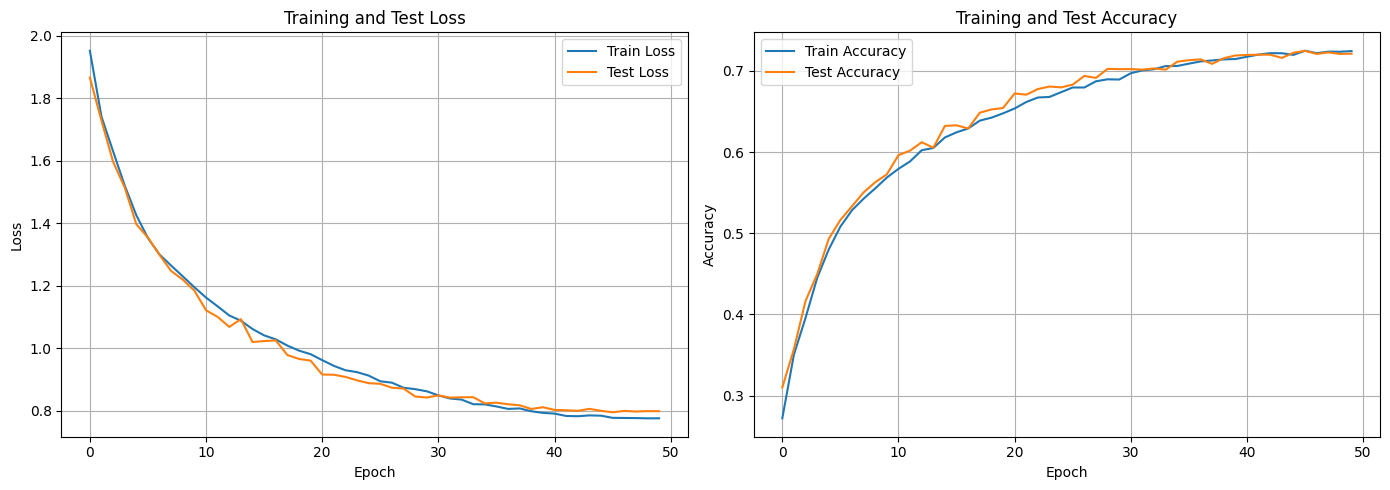

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_losses, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_accs, label='Train Accuracy')
axes[1].plot(test_accs, label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [12]:
test_transform_vis = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

testset_vis = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform_vis)

sample_indices = [0, 100, 500, 1000, 2000]
sample_images = [testset_vis[i][0] for i in sample_indices]
sample_labels = [testset_vis[i][1] for i in sample_indices]


Image 1: cat


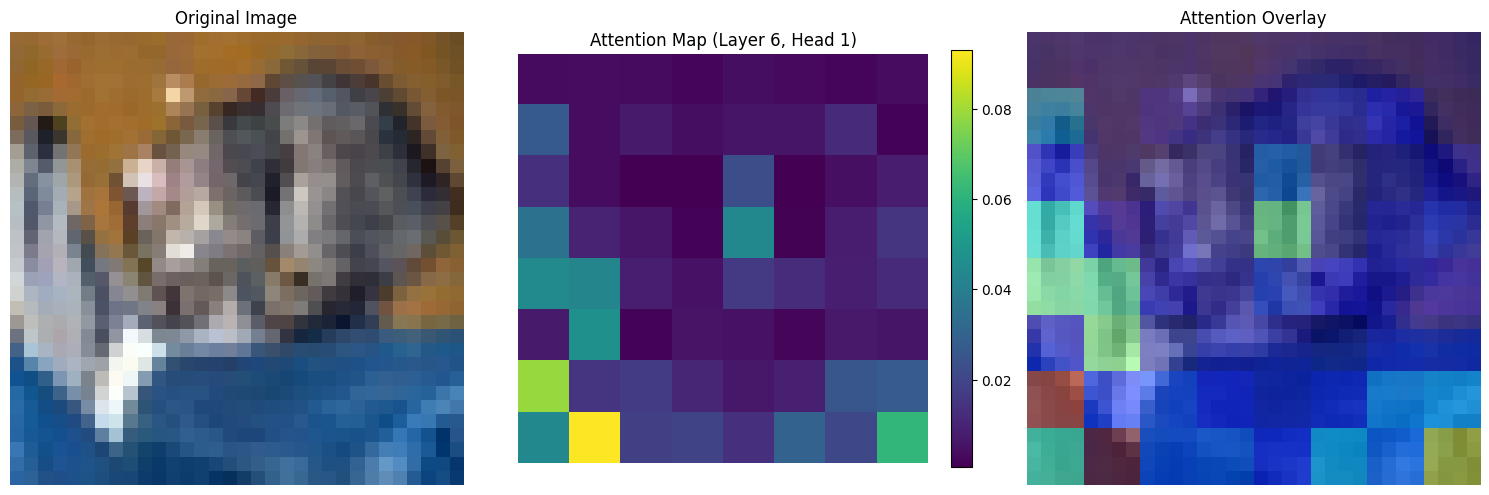


Image 2: deer


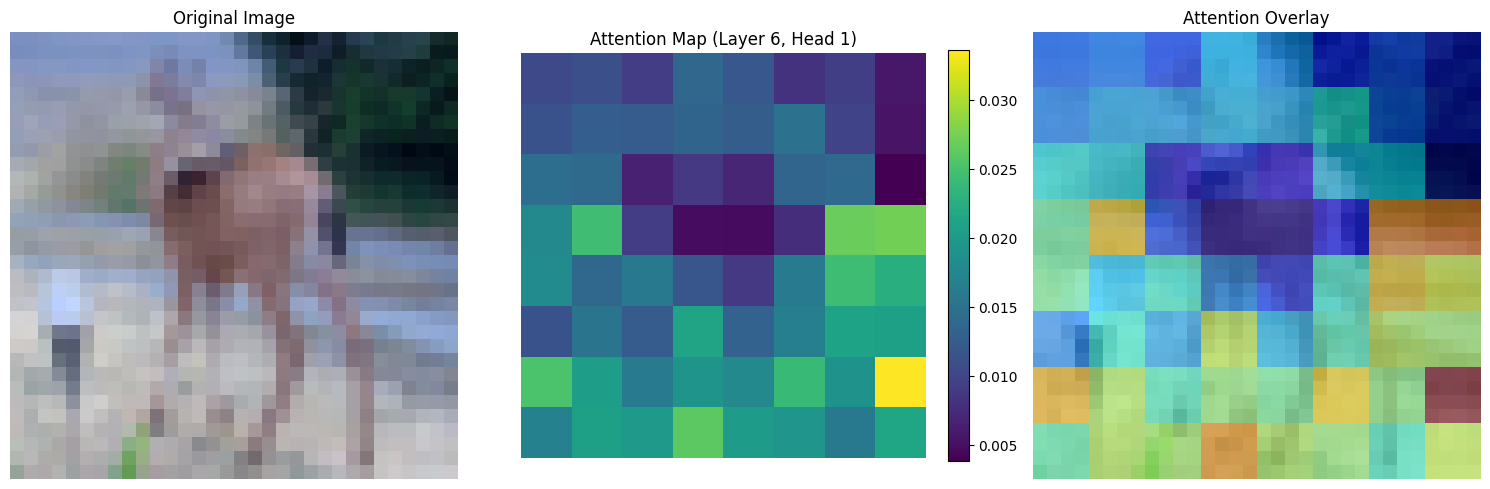


Image 3: deer


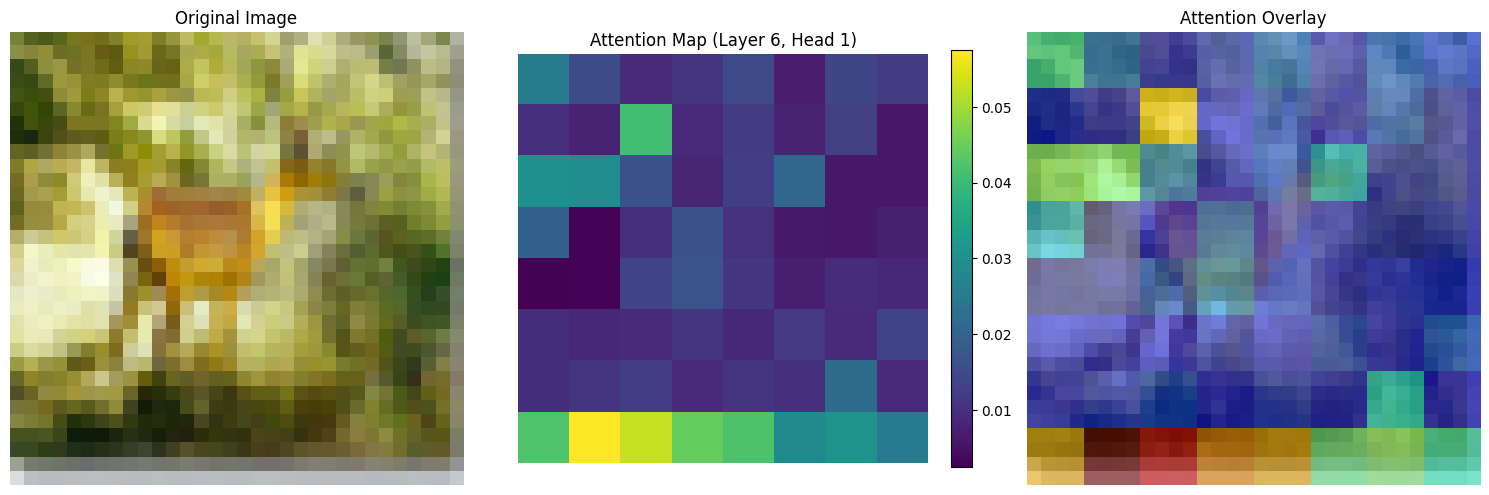

In [13]:
for idx, (image, label) in enumerate(zip(sample_images[:3], sample_labels[:3])):
    print(f'\nImage {idx+1}: {classes[label]}')
    visualize_attention(model, image, device, layer_idx=5, head_idx=0)

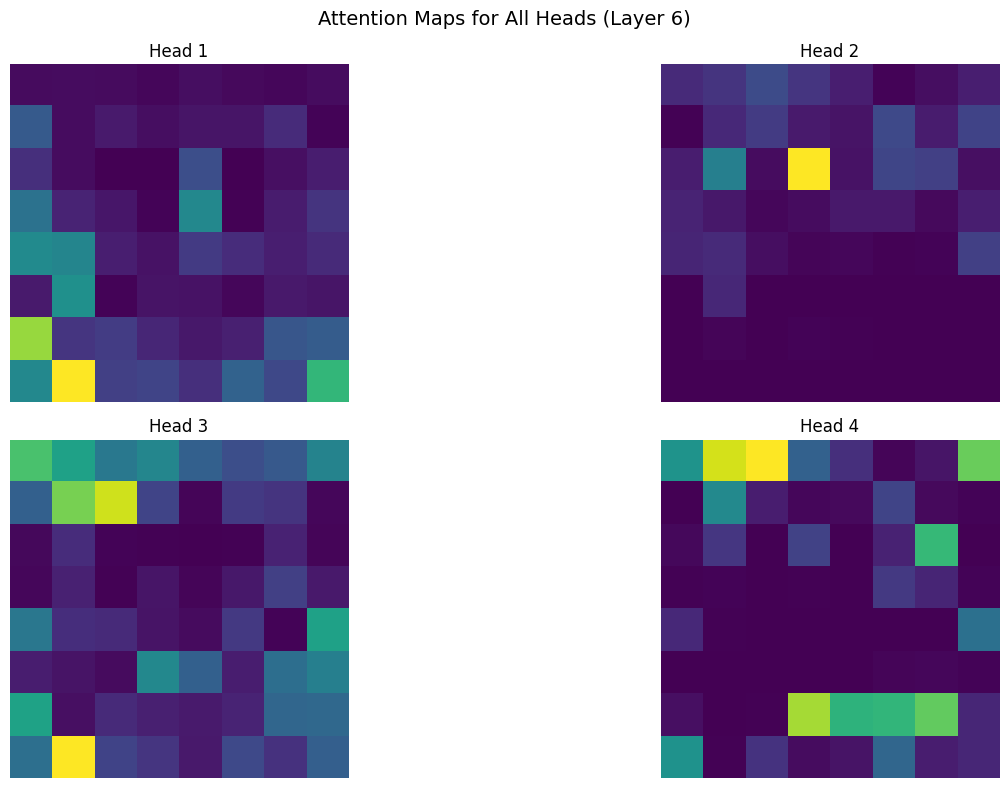

In [14]:
visualize_all_heads(model, sample_images[0], device, layer_idx=5)

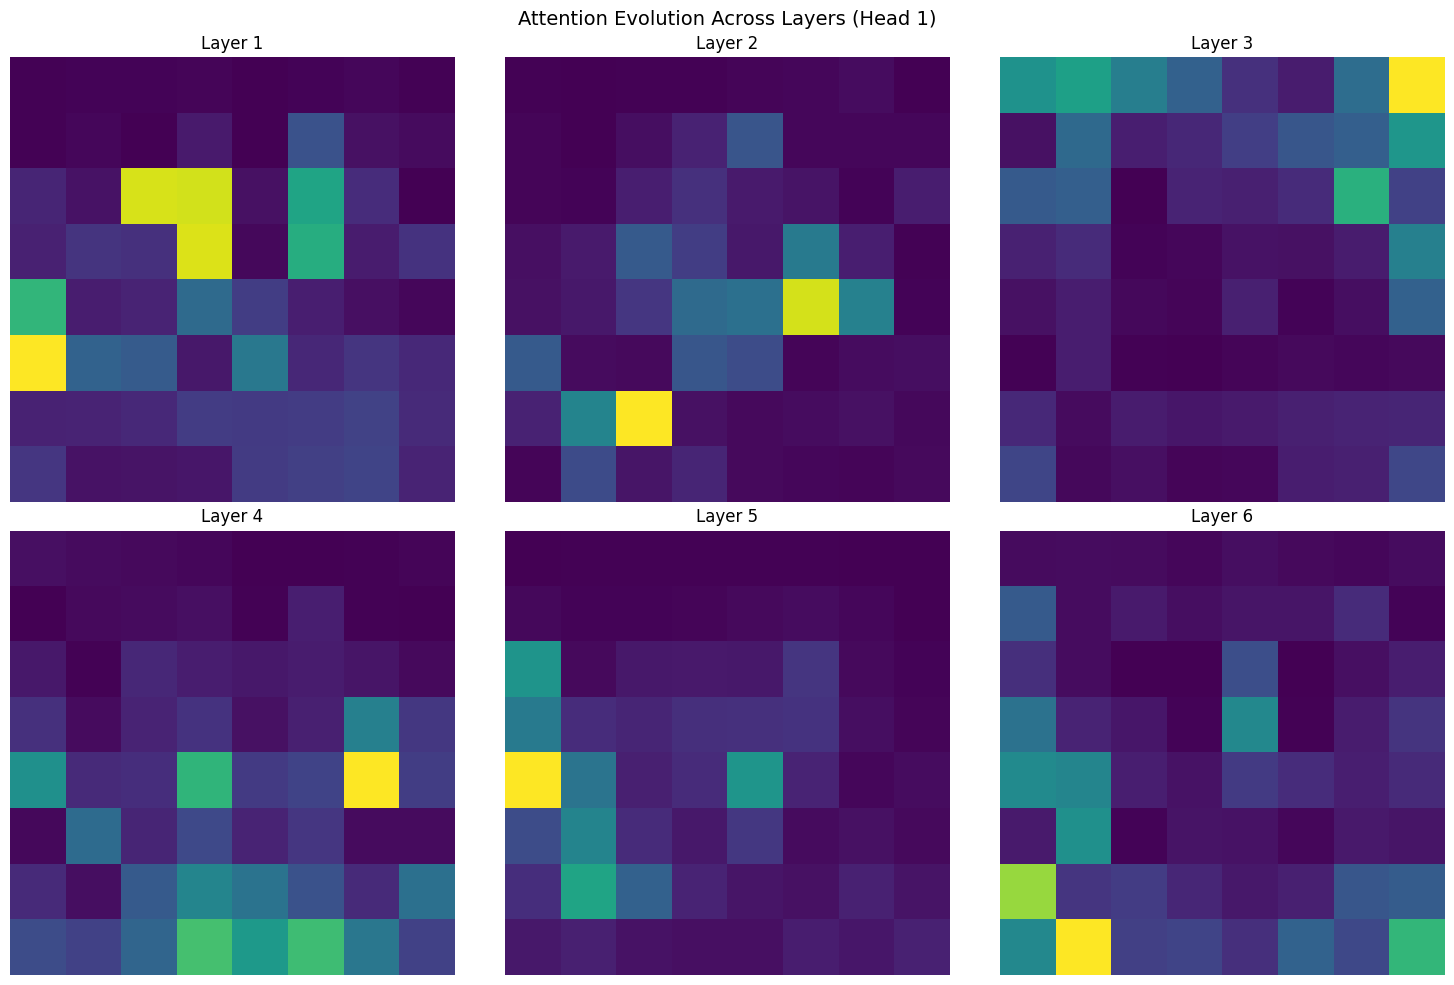

In [15]:
visualize_attention_across_layers(model, sample_images[0], device, head_idx=0)

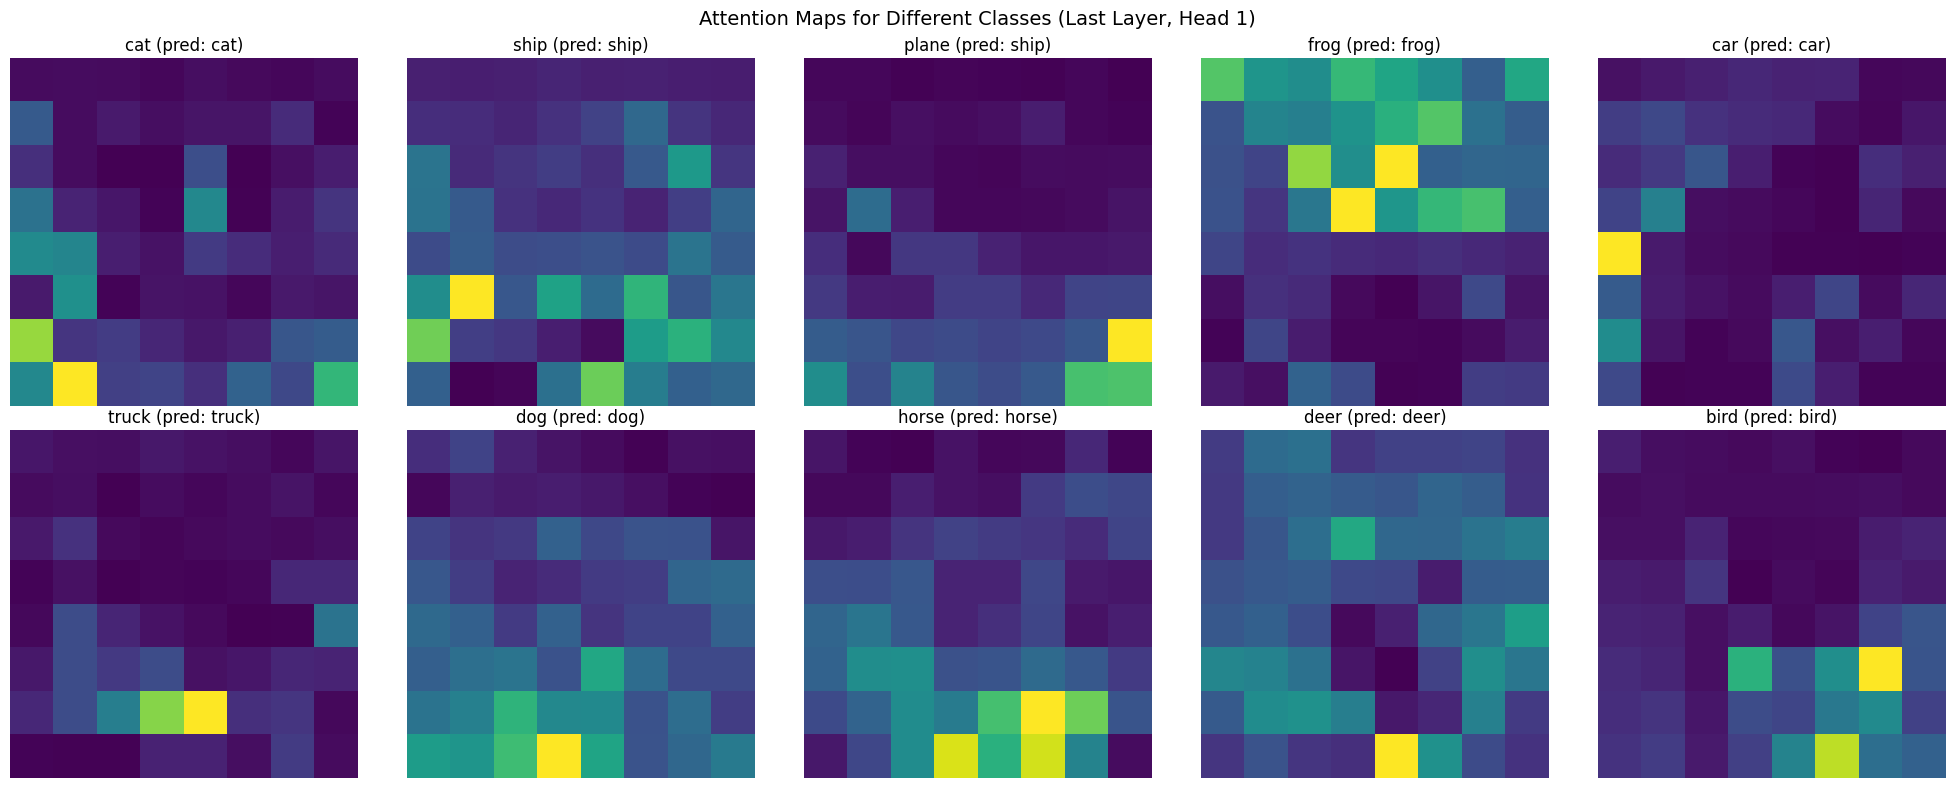

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

class_samples = {}
for i in range(len(testset_vis)):
    _, label = testset_vis[i]
    if label not in class_samples:
        class_samples[label] = i
    if len(class_samples) == 10:
        break

model.eval()
for idx, (class_idx, sample_idx) in enumerate(class_samples.items()):
    image, label = testset_vis[sample_idx]

    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred = output.argmax(dim=1).item()
        attention_weights = model.get_attention_weights()

    attn = attention_weights[-1][0, 0].cpu().numpy()
    cls_attn = attn[0, 1:]
    num_patches = int(np.sqrt(len(cls_attn)))
    cls_attn = cls_attn.reshape(num_patches, num_patches)

    row = idx // 5
    col = idx % 5

    axes[row, col].imshow(cls_attn, cmap='viridis')
    axes[row, col].set_title(f'{classes[label]} (pred: {classes[pred]})')
    axes[row, col].axis('off')

plt.suptitle('Attention Maps for Different Classes (Last Layer, Head 1)', fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
final_loss, final_acc = evaluate(model, testloader, criterion, device)
print(f'Final Test Loss: {final_loss:.4f}')
print(f'Final Test Accuracy: {final_acc:.4f}')

Final Test Loss: 0.7985
Final Test Accuracy: 0.7212


1. АРХИТЕКТУРА ViT:
   - Vision Transformer разбивает изображение на патчи (4x4 пикселя)
   - Каждый патч преобразуется в эмбеддинг и обрабатывается как токен
   - Добавляется специальный CLS-токен для классификации

2. МЕХАНИЗМ ВНИМАНИЯ:
   - Ранние слои фокусируются на локальных паттернах
   - Глубокие слои захватывают глобальные зависимости
   - Разные головы внимания специализируются на разных признаках

3. ИНТЕРПРЕТАЦИЯ КАРТ ВНИМАНИЯ:
   - Яркие области указывают на важные для классификации регионы
   - CLS-токен агрегирует информацию со всех патчей
   - Модель учится фокусироваться на объектах, а не на фоне

4. ОСОБЕННОСТИ ОБУЧЕНИЯ:
   - ViT требует больше данных для обучения чем CNN
   - Использование аугментаций критически важно
   - Regularization (dropout, weight decay) предотвращает переобучение

5. ПРАКТИЧЕСКИЕ НАБЛЮДЕНИЯ:
   - Для разных классов паттерны внимания отличаются
   - Модель корректно выделяет характерные признаки объектов
   - Ошибки классификации часто связаны с размытым вниманием


ViT изначально разрабатывался Google для предобучения на гигантских датасетах (ImageNet-21k с 14M изображений, JFT-300M с 300M изображений), где он превосходит CNN за счёт способности моделировать глобальные зависимости. На практике для небольших датасетов типа CIFAR-10 эффективнее использовать transfer learning — взять предобученные веса и дообучить на своей задаче, что даёт 95%+ точности вместо ~72% при обучении с нуля.

